In [1]:
import faiss 
import sys
import os
import math
import random
import heapq 
import time
import numpy as np
import pandas as pd
from PIL import Image
from io import StringIO,BytesIO 
import cv2
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pywt
from functools import reduce

Loading faiss with AVX2 support.


In [2]:
# SIFT
def sift_extractor(file_path):
    '''
    Description: extract \emph{sift} feature from given image
    Input: file_path - image path
    Output: des - a list of descriptors of all the keypoint from the image
    '''
    img = cv2.imread(file_path)
    gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    sift = cv2.xfeatures2d.SIFT_create()
    _,des = sift.detectAndCompute(gray,None) 

    return des

dimensions = 128 #default dimension of keypoints
index = faiss.IndexFlatL2(dimensions) #construct index
cpu_index = faiss.IndexIDMap(index)
res = faiss.StandardGpuResources() #make single gpu usable
gpu_index = faiss.index_cpu_to_gpu(res, 6, cpu_index) #sixth graphic card
imgDes = [] #deccription of image content
imgDet = [] #detailed information of image
root_dir = '/data/fjsdata/fundus/iSee/iSee_multi_dataset/' #the path of images
tstart = time.time()
for itype in ['AMD','DR','glaucoma','myopia','norm']: #AMD-720, DR-270, glaucoma-450,myopia-790,norm-7770,all-10000
    image_dir = root_dir+'img_data_%s'%itype
    for fname in sorted(os.listdir(image_dir)):
        image_path = os.path.join(image_dir, fname)
        if fname.endswith(".jpg"):
            try:
                des = sift_extractor(image_path)
                ids_list = np.linspace(len(imgDet), len(imgDet), num=des.shape[0], dtype="int64")
                gpu_index.add_with_ids(des, ids_list)
                imgDet.append([fname, itype, len(imgDes), len(imgDes)+des.shape[0]])
                imgDes.extend(des)
            except:
                print(fname+":"+str(image_path))
        sys.stdout.write('\r{} / {} '.format(len(imgDet),10000))
        sys.stdout.flush()
imgDes = np.array(imgDes).astype('float32') #must be float32
#save the index file,301M((604990, 128))
faiss.write_index(faiss.index_gpu_to_cpu(gpu_index), "/data/tmpexec/FF_iSee.index")
elapsed = time.time() - tstart    
print('Completed buliding index in %d seconds' % int(elapsed))

10000 / 10000 Completed buliding index in 18854 seconds


In [37]:
#evaluation
conn = ps.connect(host="127.0.0.1", user="postgres", password="postgres", database="isee")#connect postgresql 
if conn is not None:
    cur = conn.cursor() 
    #random choose test samples 10% AMD-720, DR-270, glaucoma-450,myopia-790,norm-7770,all-10000
    name_list = []
    for itype in ['AMD','DR','glaucoma','myopia','norm']:
        if itype=='AMD': num=72
        elif itype=='DR': num=27
        elif itype=='glaucoma': num=45
        elif itype=='myopia': num=79
        else: num =100
        command ="select name,type from isee_multi where type =%s order by random() limit %s;"
        params = (itype, num)
        cur.execute(command, params)
        for name,itype in cur.fetchall():
            name_list.append(name)
    cur.close()
conn.close()
#index = faiss.read_index("/data/tmpexec/FF_iSee.index") #read index from file
cpu_index = faiss.index_gpu_to_cpu(gpu_index)
for topk in [5,10,15]:
    HR =[] #Hit ratio 
    MAP =[] #mean average precision
    for i, val in enumerate(imgDet):
        sname, stype, stpos, endpos = imgDet[i]
        if sname in name_list:  #the query object
            ids_list = np.linspace(i, i, num=1, dtype="int64")
            cpu_index.remove_ids(ids_list)
            scores, neighbors = cpu_index.search(imgDes[int(stpos):int(endpos)+1], k=topk)
            ids_list = np.linspace(i, i, num=len(imgDes[int(stpos):int(endpos)+1]), dtype="int64")
            cpu_index.add_with_ids(imgDes[int(stpos):int(endpos)+1], ids_list)
            #perfromance
            pos_len = 0
            rank_len = 0
            for j in range(topk):
                rank = np.argmax(np.bincount(neighbors[:,j]))
                dname, dtype, _, _ = imgDet[rank]
                rank_len=rank_len+1
                if stype==dtype:  #hit
                    HR.append(1)
                    pos_len = pos_len +1
                    MAP.append(pos_len/rank_len) 
                else: 
                    HR.append(0)
                    MAP.append(0)
        sys.stdout.write('\r{} / {} '.format(i,10000))
        sys.stdout.flush()
    print("HR@{}={:.6f}, MAP@{}={:.6f}".format(topk,np.mean(HR),topk,np.mean(MAP)))   

9999 / 10000 HR@5=0.267630, MAP@5=0.190848
9999 / 10000 HR@10=0.269364, MAP@10=0.163827
9999 / 10000 HR@15=0.263776, MAP@15=0.150030


[('100217.jpg', 'AMD'), ('100217.jpg', 'DR'), ('482777.jpg', 'DR'), ('96776.jpg', 'DR'), ('482777.jpg', 'DR'), ('482777.jpg', 'DR')]


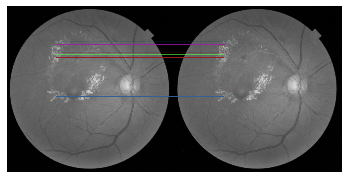

In [51]:
image_list = []
cpu_index2 = faiss.index_gpu_to_cpu(gpu_index)
for i, val in enumerate(imgDet):
    sname, stype, stpos, endpos = imgDet[i]
    if sname in name_list: #get a query image
        image_list.append((sname, stype))
        ids_list = np.linspace(i, i, num=1, dtype="int64")
        cpu_index2.remove_ids(ids_list)
        scores, neighbors = cpu_index2.search(imgDes[int(stpos):int(endpos)+1], k=5)
        for j in range(5):
            rank = np.argmax(np.bincount(neighbors[:,j]))
            dname, dtype, _, _ = imgDet[rank]
            image_list.append((dname, dtype))
        break
print (image_list)
simage = image_list[0]
dimage = image_list[1]
#feature matching
image_s = cv2.imread('/data/fjsdata/fundus/iSee/iSee_multi_dataset/'+'img_data_%s'%simage[1]+'/%s'%simage[0])
image_s = cv2.cvtColor(image_s, cv2.COLOR_BGR2GRAY)
iamge_d = cv2.imread('/data/fjsdata/fundus/iSee/iSee_multi_dataset/'+'img_data_%s'%dimage[1]+'/%s'%dimage[0])
iamge_d = cv2.cvtColor(iamge_d, cv2.COLOR_BGR2GRAY)
sift = cv2.xfeatures2d.SIFT_create()
keypoints_1, descriptors_1 = sift.detectAndCompute(image_s,None)
keypoints_2, descriptors_2 = sift.detectAndCompute(iamge_d,None)

bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
matches = bf.match(descriptors_1,descriptors_2)
matches = sorted(matches, key = lambda x:x.distance)

img3 = cv2.drawMatches(image_s, keypoints_1, iamge_d, keypoints_2, matches[:50], iamge_d, flags=2)
plt.imshow(img3)
plt.axis('off')
plt.show()

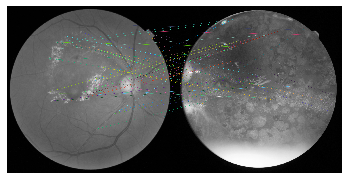

In [56]:
simage = image_list[0]
dimage = image_list[2]
#feature matching
image_s = cv2.imread('/data/fjsdata/fundus/iSee/iSee_multi_dataset/'+'img_data_%s'%simage[1]+'/%s'%simage[0])
image_s = cv2.cvtColor(image_s, cv2.COLOR_BGR2GRAY)
iamge_d = cv2.imread('/data/fjsdata/fundus/iSee/iSee_multi_dataset/'+'img_data_%s'%dimage[1]+'/%s'%dimage[0])
iamge_d = cv2.cvtColor(iamge_d, cv2.COLOR_BGR2GRAY)
sift = cv2.xfeatures2d.SIFT_create()
keypoints_1, descriptors_1 = sift.detectAndCompute(image_s,None)
keypoints_2, descriptors_2 = sift.detectAndCompute(iamge_d,None)

bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
matches = bf.match(descriptors_1,descriptors_2)
matches = sorted(matches, key = lambda x:x.distance)

img3 = cv2.drawMatches(image_s, keypoints_1, iamge_d, keypoints_2, matches[:50], iamge_d, flags=2)
plt.imshow(img3)
plt.axis('off')
plt.show()

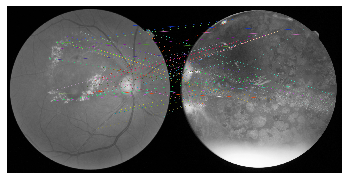

In [55]:
simage = image_list[0]
dimage = image_list[5]
#feature matching
image_s = cv2.imread('/data/fjsdata/fundus/iSee/iSee_multi_dataset/'+'img_data_%s'%simage[1]+'/%s'%simage[0])
image_s = cv2.cvtColor(image_s, cv2.COLOR_BGR2GRAY)
iamge_d = cv2.imread('/data/fjsdata/fundus/iSee/iSee_multi_dataset/'+'img_data_%s'%dimage[1]+'/%s'%dimage[0])
iamge_d = cv2.cvtColor(iamge_d, cv2.COLOR_BGR2GRAY)
sift = cv2.xfeatures2d.SIFT_create()
keypoints_1, descriptors_1 = sift.detectAndCompute(image_s,None)
keypoints_2, descriptors_2 = sift.detectAndCompute(iamge_d,None)

bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
matches = bf.match(descriptors_1,descriptors_2)
matches = sorted(matches, key = lambda x:x.distance)

img3 = cv2.drawMatches(image_s, keypoints_1, iamge_d, keypoints_2, matches[:50], iamge_d, flags=2)
plt.imshow(img3)
plt.axis('off')
plt.show()

In [2]:
#Extract features with wavelet transform and get fingerprint
def avhash(im): #Perceptual hash algorithm
    if not isinstance(im, Image.Image):
        im = Image.open(im)
    im = im.resize((8, 8), Image.ANTIALIAS).convert('L')
    avg = reduce(lambda x, y: x + y, im.getdata()) / 64.
    return reduce(lambda x, yz: x | (yz[1] << yz[0]),
                  enumerate(map(lambda i: 0 if i < avg else 1, im.getdata())),
                  0)

imgWF = [] #record features
imgName = [] #record name and type
root_dir = '/data/fjsdata/fundus/iSee/iSee_multi_dataset/' #the path of images
#AMD-720, DR-270, glaucoma-450,myopia-790,norm-7770,all-10000
for itype in ['AMD','DR','glaucoma','myopia','norm']:
    image_dir = root_dir+'img_data_%s'%itype
    for fname in sorted(os.listdir(image_dir)):
        image_path = os.path.join(image_dir, fname)
        if fname.endswith(".jpg"):
            try:
                img = cv2.imread(image_path)
                if img is not None:
                    img = cv2.resize(img, (16, 16))#resize image 1920x1942
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float32)  #turn  multi-channel to single-channel
                    cA, (cH, cV, cD) = pywt.dwt2(data=img, wavelet='haar')#Single level Discrete Wavelet Transform.
                    imgWF.append(cA.flatten())
                    #imgSign = avhash(image_path)#pha algorithm
                    imgName.append([fname, itype])
            except:
                print(fname+":"+str(image_path))
        sys.stdout.write('\r{} / {} '.format(len(imgWF),10000))
        sys.stdout.flush()
imgWF = np.array(imgWF).astype('float32') #must be float32

10000 / 10000 

In [4]:
# build index
tstart = time.time()
dimensions = 8*8
cpu_index = faiss.IndexFlatL2(dimensions) #construct index
res = faiss.StandardGpuResources() #make single gpu usable
gpu_index = faiss.index_cpu_to_gpu(res, 6, cpu_index) #sixth graphic card
#gpu_index = faiss.index_cpu_to_all_gpus(cpu_index) #make all gpu usable
gpu_index.add(imgWF) #add data to index
elapsed = time.time() - tstart    
print('Completed buliding index in %d seconds' % int(elapsed))
faiss.write_index(faiss.index_gpu_to_cpu(gpu_index), "/data/tmpexec/FF_iSee.index")#save the index file

Completed buliding index in 2 seconds


In [5]:
gpu_index = faiss.read_index("/data/tmpexec/FF_iSee.index") #read index from file
#query
queryEx = np.array(imgWF).astype('float32')[0:1] # query by id=0
tstart = time.time()
scores, neighbors = gpu_index.search(queryEx, k=10)
elapsed = time.time() - tstart   
print (elapsed)
print('Completed buliding index in %d seconds' % (elapsed))
print(scores)
print(neighbors)
print (imgName[7058])

0.028519630432128906
Completed buliding index in 0 seconds
[[    0.     7829.252 10125.502 10892.5   11901.998 12543.5   12678.251
  12708.25  12785.248 12957.496]]
[[   0 2729   94 3508 7058 7070 8533 7169 5645  943]]
['88884.jpg', 'norm']


In [6]:
#evaluation
gpu_index = faiss.read_index("/data/tmpexec/FF_iSee.index") #read index from file
for topk in [5,10,15]:
    HR =[] #Hit ratio 
    MAP =[] #mean average precision
    for i, val in enumerate(imgName[0:1000]):
            scores, neighbors = gpu_index.search(imgWF[i:i+1], k=topk)
            #perfromance
            pos_len = 0
            rank_len = 0
            for j in neighbors[0].tolist():
                sname, stype = imgName[i]
                dname, dtype = imgName[j]
                rank_len=rank_len+1
                if stype==dtype:  #hit
                    HR.append(1)
                    pos_len = pos_len +1
                    MAP.append(pos_len/rank_len) 
                else: 
                    HR.append(0)
                    MAP.append(0)   
    print("HR@{}={:.6f}, MAP@{}={:.6f}".format(topk,np.mean(HR),topk,np.mean(MAP)))              

HR@5=0.258200, MAP@5=0.234500
HR@10=0.164500, MAP@10=0.128834
HR@15=0.132200, MAP@15=0.090736


In [2]:
##https://github.com/facebookresearch/faiss/wiki
import numpy as np
import faiss     # make faiss available
d = 64                          # dimension
nb = 10000                      # database size
nq = 1000                       # nb of queries
np.random.seed(1234)             # make reproducible
xb = np.random.random((nb, d)).astype('float32')
xb[:, 0] += np.arange(nb) / 1000.
xq = np.random.random((nq, d)).astype('float32')
xq[:, 0] += np.arange(nq) / 1000.
index = faiss.IndexFlatL2(d)   # build the index
#index = faiss.index_cpu_to_all_gpus(cpu_index) #make all gpu usable
              # neighbors of the 5 last queries
#faiss.write_index(faiss.index_gpu_to_cpu(index), "/data/tmpexec/FF_iSee.index")#save the index file
#index = faiss.read_index("/data/tmpexec/FF_iSee.index") #read index from file
print(index.is_trained)
index.add(xb)                  # add vectors to the index
print(index.ntotal)
k = 4                          # we want to see 4 nearest neighbors
D, I = index.search(xb[:5], k) # sanity check
print(I)
print(D)
D, I = index.search(xq, k)     # actual search
print(I[:5])                   # neighbors of the 5 first queries
print(I[-5:]) 

True
10000
[[  0 393 363  78]
 [  1 555 277 364]
 [  2 304 101  13]
 [  3 173  18 182]
 [  4 288 370 531]]
[[0.        7.1751738 7.20763   7.2511625]
 [0.        6.3235645 6.684581  6.799946 ]
 [0.        5.7964087 6.391736  7.2815123]
 [0.        7.2779055 7.527987  7.6628466]
 [0.        6.7638035 7.2951202 7.3688145]]
[[ 794   72  515 1204]
 [ 393  919  424  923]
 [ 688  806  763  185]
 [ 950  230  317  703]
 [ 199  409  411  794]]
[[1682 1663 1766 1759]
 [1225 1501 1193 1656]
 [1095 1369 1308  958]
 [1346 1386 1136  664]
 [ 627  308  678  856]]


In [2]:
nlist = 100
k = 4
quantizer = faiss.IndexFlatL2(d)  # the other index
index = faiss.IndexIVFFlat(quantizer, d, nlist)
assert not index.is_trained
index.train(xb)
assert index.is_trained

index.add(xb)                  # add may be a bit slower as well
D, I = index.search(xq, k)     # actual search
print(I[-5:])                  # neighbors of the 5 last queries
index.nprobe = 10              # default nprobe is 1, try a few more
D, I = index.search(xq, k)
print(I[-5:])                  # neighbors of the 5 last queries

[[1597 1273 1001  441]
 [1824 1457 1739 1183]
 [ 929  794  956  785]
 [1190  735 1363  335]
 [ 535   83  767  484]]
[[1682 1663 1766 1759]
 [1225 1501 1193 1656]
 [1095 1369 1308  958]
 [1346 1136  664  775]
 [ 627  308  678  856]]


In [3]:
nlist = 100
m = 8                             # number of subquantizers
k = 4
quantizer = faiss.IndexFlatL2(d)  # this remains the same
index = faiss.IndexIVFPQ(quantizer, d, nlist, m, 8)
                                    # 8 specifies that each sub-vector is encoded as 8 bits
index.train(xb)
index.add(xb)
D, I = index.search(xb[:5], k) # sanity check
print(I)
print(D)
index.nprobe = 10              # make comparable with experiment above
D, I = index.search(xq, k)     # search
print(I[-5:])

[[   0  268 1124   39]
 [   1    5  890  639]
 [   2  304  801  642]
 [   3  182   64  554]
 [   4  181   61  159]]
[[1.4082367 5.9878635 6.0450835 6.2460175]
 [1.2857159 6.8532023 6.8909144 6.905564 ]
 [1.3978342 4.4928756 7.0645766 7.076585 ]
 [0.9898314 6.03894   6.6203237 6.796782 ]
 [0.9522777 6.3987713 6.464768  6.553776 ]]
[[ 480 2347 1759 1682]
 [ 664 1656 1225 1423]
 [  85 1279 1369 1361]
 [1346  735 1697 1707]
 [ 834 1211  678  796]]


In [5]:
res = faiss.StandardGpuResources()  # use a single GPU
# build a flat (CPU) index
index_flat = faiss.IndexFlatL2(d)
# make it into a gpu index
gpu_index_flat = faiss.index_cpu_to_gpu(res, 0, index_flat)
gpu_index_flat.add(xb)         # add vectors to the index
print(gpu_index_flat.ntotal)

k = 4                          # we want to see 4 nearest neighbors
D, I = gpu_index_flat.search(xq, k)  # actual search
print(I[:5])                   # neighbors of the 5 first queries
print(I[-5:])                  # neighbors of the 5 last queries

10000
[[ 794   72  515 1204]
 [ 393  919  424  923]
 [ 688  806  763  185]
 [ 950  230  317  703]
 [ 199  409  411  794]]
[[1682 1663 1766 1759]
 [1225 1501 1193 1656]
 [1095 1369 1308  958]
 [1346 1386 1136  664]
 [ 627  308  678  856]]


In [3]:
ngpus = faiss.get_num_gpus()

print("number of GPUs:", ngpus)

cpu_index = faiss.IndexFlatL2(d)

gpu_index = faiss.index_cpu_to_all_gpus( cpu_index) # build the index
    

gpu_index.add(xb)              # add vectors to the index
print(gpu_index.ntotal)

k = 4                          # we want to see 4 nearest neighbors
D, I = gpu_index.search(xq, k) # actual search
print(I[:5])                   # neighbors of the 5 first queries
print(I[-5:])                  # neighbors of the 5 last queries

number of GPUs: 8
10000
[[ 794   72  515 1204]
 [ 393  919  424  923]
 [ 688  806  763  185]
 [ 950  230  317  703]
 [ 199  409  411  794]]
[[1682 1663 1766 1759]
 [1225 1501 1193 1656]
 [1095 1369 1308  958]
 [1346 1386 1136  664]
 [ 627  308  678  856]]


In [5]:
d = 32  # data dimension
cs = 4  # code size (bytes)

# train set 
nt = 10000
xt = np.random.rand(nt, d).astype('float32')

# dataset to encode (could be same as train)
n = 20000
x = np.random.rand(n, d).astype('float32')

pq = faiss.ProductQuantizer(d, cs, 8)#ProductQuantizer object can be used to encode or decode vectors to codes:
pq.train(xt)

# encode 
codes = pq.compute_codes(x)

# decode
x2 = pq.decode(codes)

# compute reconstruction error
avg_relative_error = ((x - x2)**2).sum() / (x ** 2).sum()
print (avg_relative_error)

0.06634252


In [7]:
d = 32  # data dimension

# train set 
nt = 10000
xt = np.random.rand(nt, d).astype('float32')

# dataset to encode (could be same as train)
n = 20000
x = np.random.rand(n, d).astype('float32')

# QT_8bit allocates 8 bits per dimension (QT_4bit also works)
sq = faiss.ScalarQuantizer(d, faiss.ScalarQuantizer.QT_8bit)
sq.train(xt)

# encode 
codes = sq.compute_codes(x)

# decode
x2 = sq.decode(codes)

# compute reconstruction error
avg_relative_error = ((x - x2)**2).sum() / (x ** 2).sum()
print (avg_relative_error)

3.8421013e-06


In [9]:
# random training data 
mt = np.random.rand(1000, 40).astype('float32')
mat = faiss.PCAMatrix (40, 10)#Let's reduce 40D vectors to 10D.
mat.train(mt)
assert mat.is_trained
tr = mat.apply_py(mt)
# print this to show that the magnitude of tr's columns is decreasing
print ((tr ** 2).sum(0))

[118.798096 116.06865  111.3146   108.086205 106.272224 105.0623
 103.40434  101.49851   97.25359   95.923416]
